# Preprocess data

In [1]:
import numpy as np
import os
import pandas as pd
import seaborn as sns
import skimage.io

import config
from utils.normalize2 import normalize_features02, normalize_labels

%matplotlib inline

## Load dataset

In [2]:
from utils.features02_dlib import FEATURES, TARGETS

In [3]:
feat_types = {f:np.int32 for f in FEATURES}

In [4]:
feat_types.update({
    'eye_right_image':  np.str,
    'eye_left_image':  np.str,
    # Shot
    'y': np.int32,
    'x': np.int32,
    'score': np.int32,
    'timestamp':  np.int32,
    'img_path':  np.str,
    'img': np.str,  # Relative to the raw dataset

    # Game
    'game_id': np.str,
    'glasses': np.bool,
    'screen_diagonal': np.float,
    'camera_position': np.str,
    'screen_height': np.int32,
    'screen_width': np.int32,
})

In [5]:
# Load dataset
data = pd.read_csv(
    config.PATH_DATA_FEATURES02_DLIB_AUGMENTED_CSV,
    usecols=feat_types
)

In [10]:
import seaborn as sns
%matplotlib inline

In [ ]:
data['score']

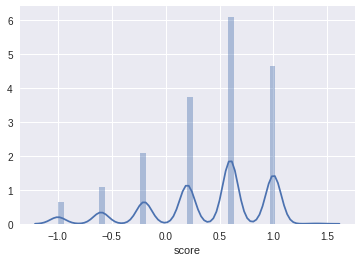

In [13]:
sns.distplot((((data['score']-5)/5)-0.5)*2)

In [9]:
data['score'].describe()

count    24075.000000
mean         8.507664
std          1.331636
min          5.000000
25%          8.000000
50%          9.000000
75%         10.000000
max         11.000000
Name: score, dtype: float64

## Scale

* x axis: [-1, 1]
* y axis: [-1, 1]

In [6]:
normalize_features02(data, FEATURES, config.WEBCAM_WIDTH, config.WEBCAM_HEIGHT)
normalize_features02(data,TARGETS, config.SCREEN_WIDTH, config.SCREEN_HEIGHT)


## Delete rows not in images

In order not to generate all the augmented data again, I only delete wrong samples from the 'raw' dataset an load augmented samples that are remaining samples in 'raw'.

In [ ]:
from utils.data import Data

raw_data = Data(config.PATH_DATA_RAW)
raw_data_list = list(raw_data.iterate())
raw_imgs = {d['img_path'] for d in raw_data_list}

In [ ]:
len(data)

In [ ]:
data = data[data['img_path'].isin(raw_imgs) ]

In [ ]:

len(data)

## Drop unneeded columns

In [ ]:
data.drop(
    labels= [
        'timestamp', 'img_path', 'img', 'game_id', 'screen_diagonal',
        'camera_position', 'screen_height', 'screen_width'
    ],
    axis=1,
    inplace=True
)

## Clean data

In [ ]:
data.describe().loc[['min','max']]

Everything makes sense.

## Target stats

In [ ]:
sns.jointplot(x="x", y="y", data=data, kind="scatter", stat_func=None, size=12, ratio=10)

In [ ]:
sns.distplot(data['y'], hist=True, norm_hist=False, kde=False)

In [ ]:
sns.distplot(data['x'], hist=True, norm_hist=False, kde=False)

## Eye images structure

In [ ]:
imgs_left = []
imgs_right = []
errors = []

for i, row in data.iterrows():
    try:
        # Scale pixel value in range [-1,1]
        imgs_left.append((skimage.io.imread(config.PATH_DATA_FEATURES02_DLIB_AUGMENTED+row['eye_left_image'])/255-0.5)*2)
    except Exception as e:
        errors.append(path)
    try:
        # Scale pixel value in range [-1,1]
        imgs_right.append((skimage.io.imread(config.PATH_DATA_FEATURES02_DLIB_AUGMENTED+row['eye_right_image'])/255-0.5)*2)
    except Exception as e:
        errors.append(path)

In [ ]:
q = (skimage.io.imread(config.PATH_DATA_FEATURES02_DLIB_AUGMENTED+row['eye_left_image'])/255-0.5)*2

## Save things

In [ ]:
if not os.path.exists(config.PATH_DATA_FEATURES02_DLIB_AUGMENTED_NORM):
    os.makedirs(config.PATH_DATA_FEATURES02_DLIB_AUGMENTED_NORM)

# CSV
data.to_csv(config.PATH_DATA_FEATURES02_DLIB_AUGMENTED_NORM_CSV, index=False)
# Images
np.save(file=config.PATH_DATA_FEATURES02_DLIB_AUGMENTED_NORM_IMGS_LEFT, arr=imgs_left)
np.save(file=config.PATH_DATA_FEATURES02_DLIB_AUGMENTED_NORM_IMGS_RIGHT, arr=imgs_right)